# Unadjusted Langevin Primal-Dual Algorithm (ULPDA) for TV-$\ell^2$ regularization

In [1]:
# Copied from TP5
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
from utils import *
from tqdm import tqdm

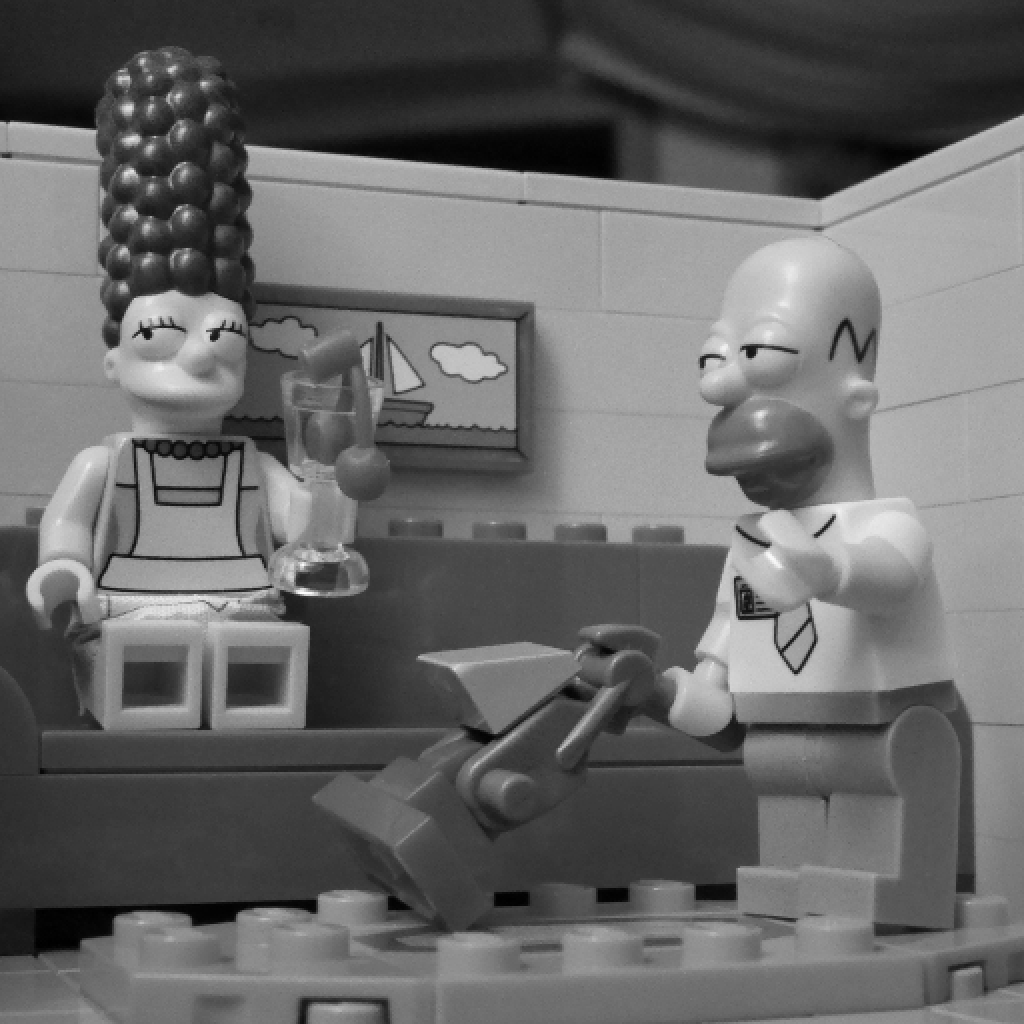

In [4]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512.png')))
M,N = u0.shape

viewimage(u0)

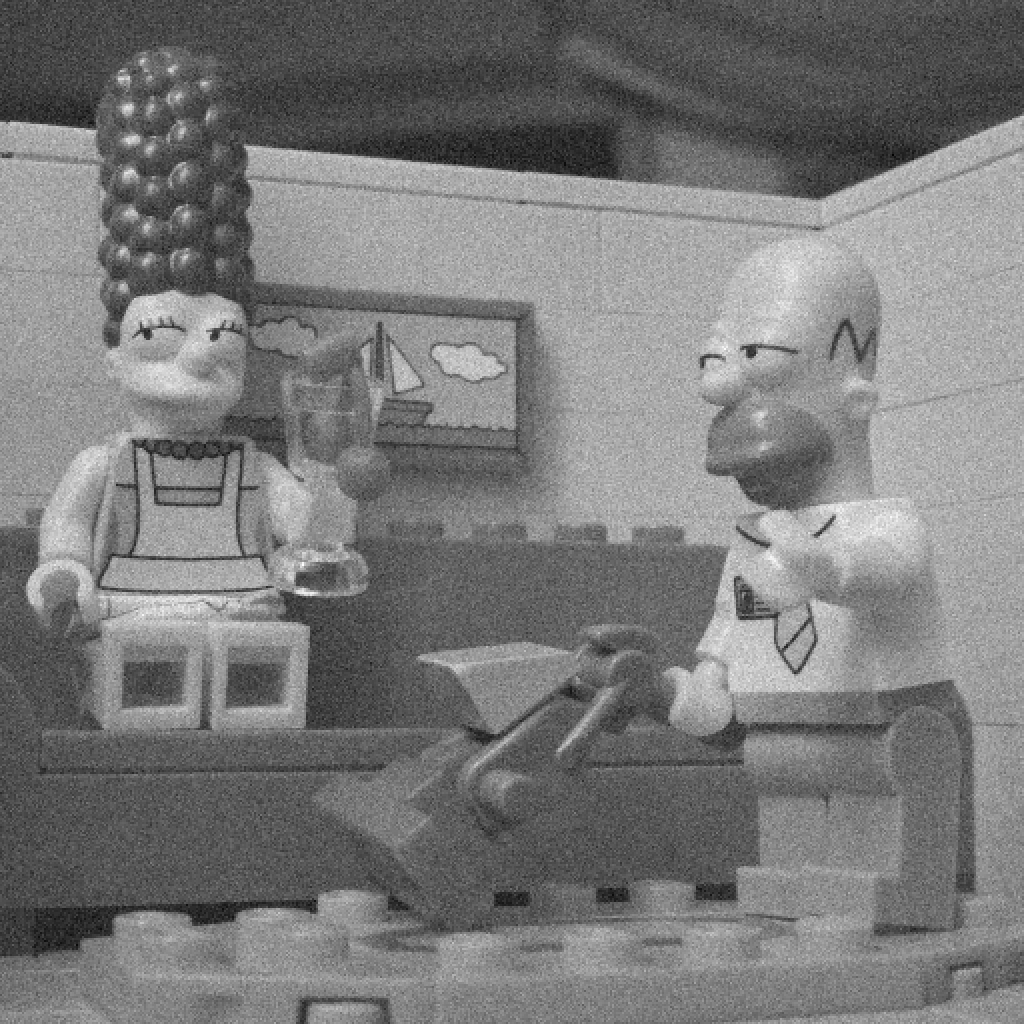

In [5]:
sigma = .05
z = u0 + sigma*torch.randn((M, N))

viewimage(z)

In [6]:
x0 = torch.randn((M, N))
p0 = torch.randn((M, N, 2))
lamb = 0.05
xhat, variances = ulpda(z, x0, p0, sigma, lamb, 1, 1e-4, .1, K=2000, burnin=1000)

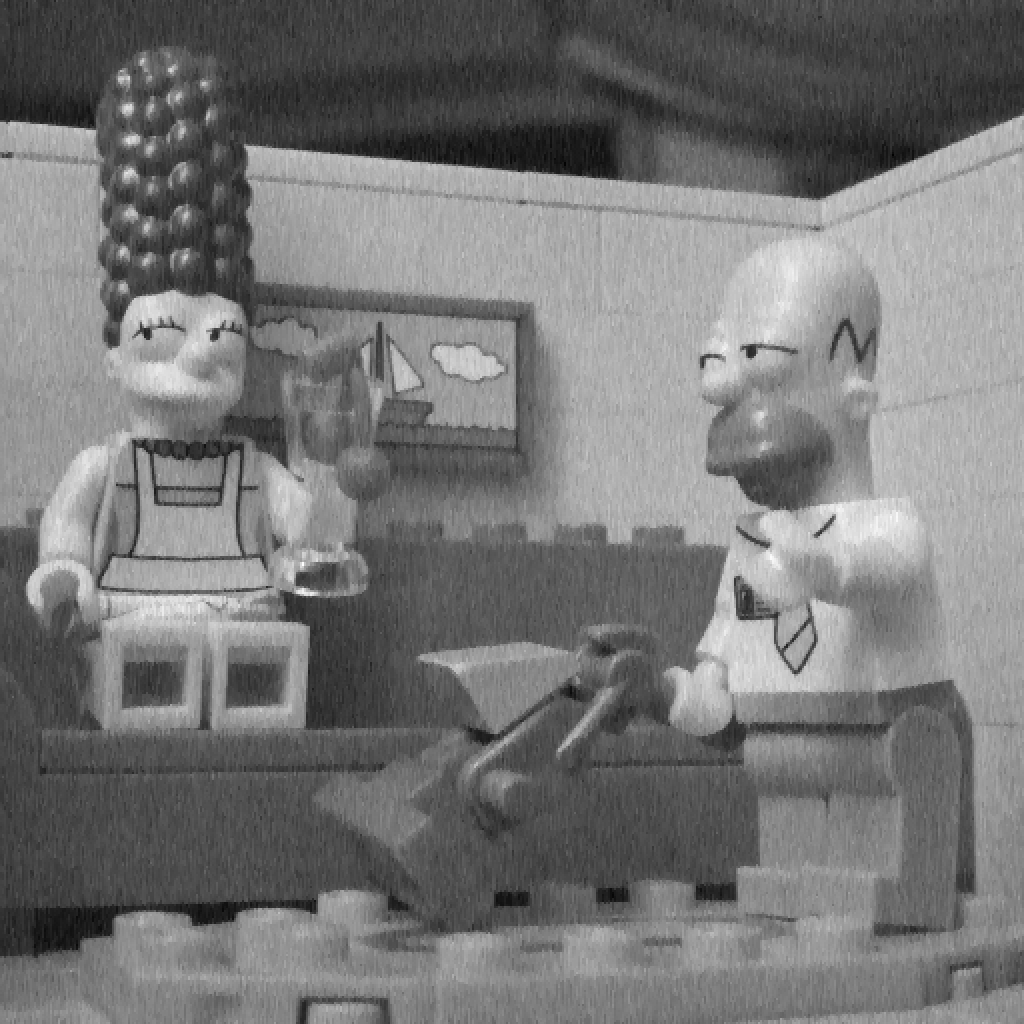

In [7]:
viewimage(xhat)

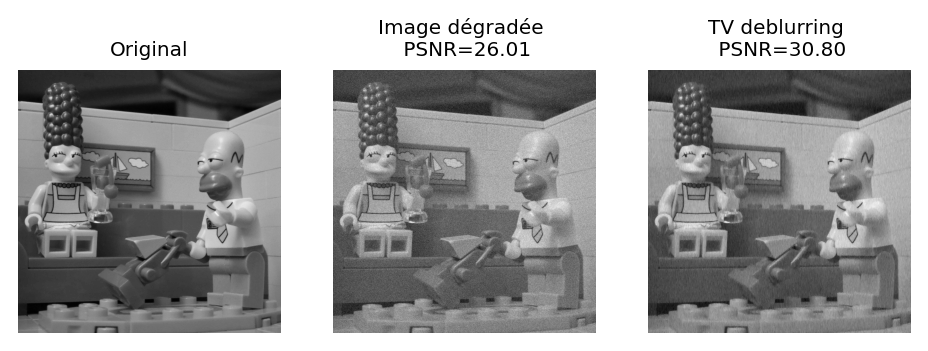

In [8]:
plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(z, cmap='gray')
plt.title('Image dégradée \n PSNR='+str2(psnr(u0,z)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(xhat, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,xhat)),fontsize=8)
plt.axis('off')
plt.show()

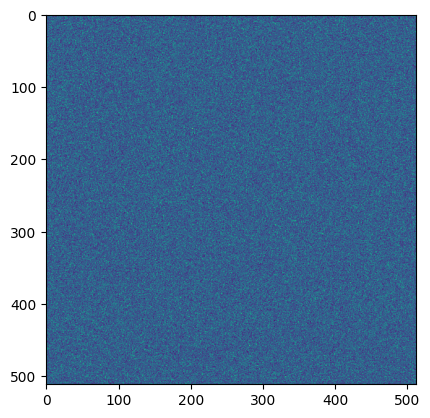

(array([1.3000e+01, 4.5000e+01, 2.3100e+02, 8.7000e+02, 2.6820e+03,
        6.5490e+03, 1.3525e+04, 2.3452e+04, 3.3891e+04, 4.1716e+04,
        4.2554e+04, 3.7520e+04, 2.7627e+04, 1.6865e+04, 8.8510e+03,
        3.8450e+03, 1.3890e+03, 4.1100e+02, 9.3000e+01, 1.5000e+01]),
 array([-3.00763249, -2.9679327 , -2.92823315, -2.88853359, -2.8488338 ,
        -2.80913401, -2.76943445, -2.7297349 , -2.6900351 , -2.65033531,
        -2.61063576, -2.5709362 , -2.53123641, -2.49153662, -2.45183706,
        -2.41213751, -2.37243772, -2.33273792, -2.29303837, -2.25333881,
        -2.21363902]),
 <BarContainer object of 20 artists>)

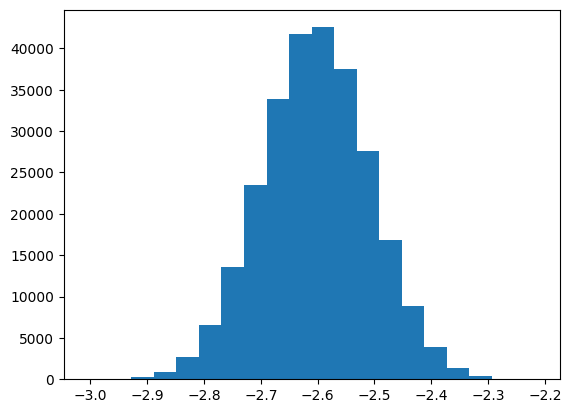

In [9]:
plt.imshow(variances)
plt.show()
plt.hist(np.log10(variances.flatten()), bins=20)

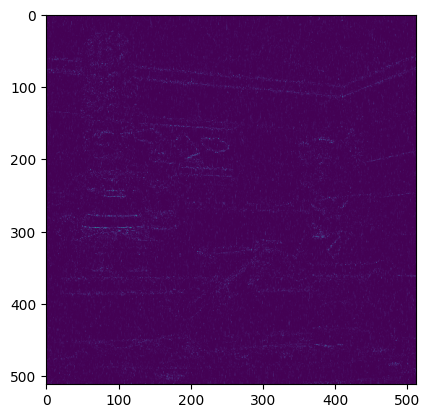

In [10]:
errors = (xhat-u0)**2
plt.imshow(errors)

In [11]:
nbins = 100
var_max = .01
bin_step = var_max/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(M):
    for j in range(N):
        bin = min(nbins-1, int(variances[i, j]/bin_step))
        errors_per_bin[bin].append(errors[i, j])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [12]:
print(list(map(len, errors_per_bin)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 20, 58, 248, 653, 1537, 2870, 4981, 7461, 10288, 13134, 15590, 17577, 18830, 19845, 19190, 18276, 17388, 15891, 13844, 12150, 10354, 8570, 7056, 5756, 4634, 3768, 2865, 2251, 1749, 1375, 1039, 703, 601, 432, 319, 221, 187, 122, 87, 72, 47, 32, 28, 15, 11, 3, 3, 6, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


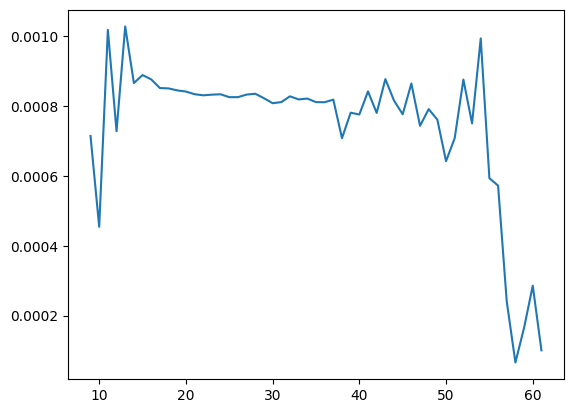

In [13]:
plt.plot(list(map(np.average, errors_per_bin)))

# Training on BSDS dataset

In [2]:
import os

In [5]:
s = []
that = []
sigma = 15/255
lamb = 0.05

for f in tqdm(os.listdir("data/train")):
    if not f.endswith(".jpg"):
        continue
    u0 = torch.tensor(rgb2gray(plt.imread(os.path.join("data/train", f))))
    M, N = u0.size()
    z = u0 + sigma*torch.randn((M, N))
    x0 = torch.randn((M, N))
    p0 = torch.randn((M, N, 2))
    xhat, variances = ulpda(z, x0, p0, sigma, lamb, s_k=1, tau_k=1e-4, theta_k=.1, K=2000, burnin=1000)
    err = (xhat-u0)**2
    s.extend(err.flatten().tolist())
    that.extend(variances.flatten().tolist())

 11%|█▏        | 23/201 [01:18<10:50,  3.65s/it]